In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import sys
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
train_dir = '../input/severstal-steel-defect-detection/' 
train_image_dir = os.path.join(train_dir, 'train_images') 
train = pd.read_csv(os.path.join(train_dir, 'train.csv'))
train['ClassId_EncodedPixels'] = train.apply(lambda row: (row['ClassId'], row['EncodedPixels']), axis = 1)
grouped_EncodedPixels = train.groupby('ImageId')['ClassId_EncodedPixels'].apply(list)
img_h=256
img_w=256
k_size=3
batch_size=10
epochs=1
train=train.dropna(subset=['EncodedPixels'])


In [2]:
def rle2mask(rle,img):
	width=img.shape[0]
	length=img.shape[1]
	mask= np.zeros(width*length).astype(np.uint8)
	rle=rle.split()
	starts = rle[0::2]
	lengths = rle[1::2]
	for i in range(len(starts)):
		mask[int(starts[i]):(int(starts[i])+int(lengths[i]))]=1
	return np.flipud(np.rot90(mask.reshape(length, width), k=1 ) )


In [3]:
train.head()

,ImageId,ClassId,EncodedPixels,ClassId_EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,"(1, 29102 12 29346 24 29602 24 29858 24 30114 ..."
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...,"(3, 18661 28 18863 82 19091 110 19347 110 1960..."
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,"(1, 37607 3 37858 8 38108 14 38359 20 38610 25..."
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,"(4, 131973 1 132228 4 132483 6 132738 8 132993..."
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...,"(3, 229501 11 229741 33 229981 55 230221 77 23..."


In [4]:
print(len(train.ImageId))

7095


Text(0.5, 1.0, 'Number of images for each class')

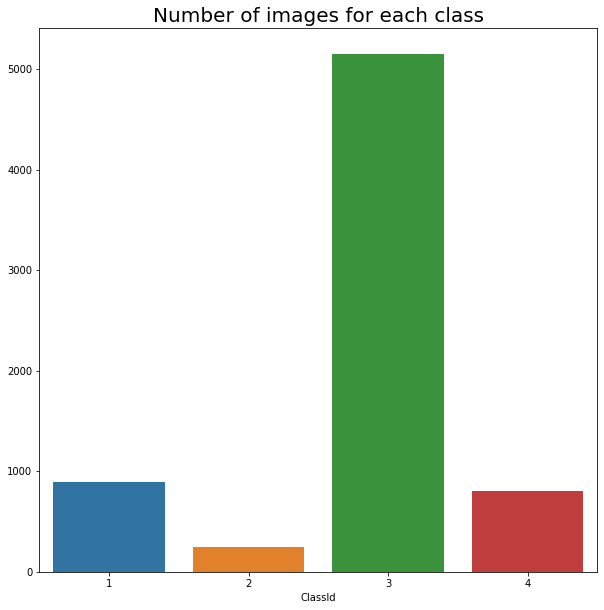

In [5]:
plt.figure(figsize=(10,10))
sns.barplot(x=train.ClassId.value_counts().index,y=train.ClassId.value_counts())
plt.ylabel('')
plt.xlabel('ClassId')
plt.title("Number of images for each class",size=20)

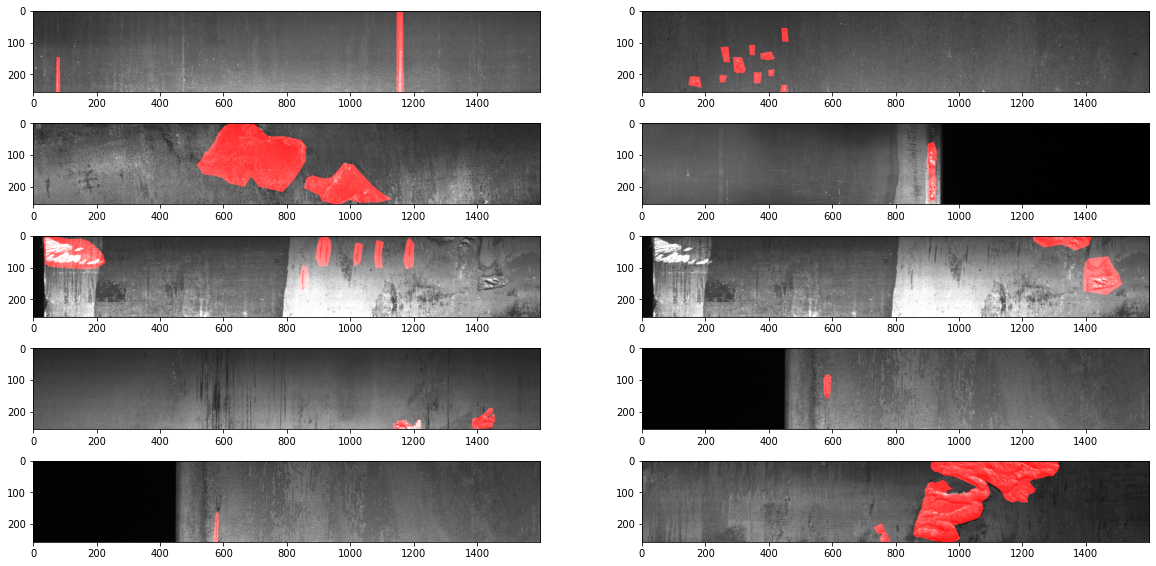

In [6]:
fig=plt.figure(figsize=(20,10))
col=2
row=5
for i in range(1,11):
	fig.add_subplot(row,col,i)
	Graph=train['ImageId'][i]
	img_new=cv2.imread("../input/severstal-steel-defect-detection/train_images/"+Graph)
	img_new= cv2.cvtColor(img_new,cv2.COLOR_BGR2RGB)
	mask = rle2mask(train['EncodedPixels'].iloc[i], img_new)
	img_new[mask==1,0] = 255
	plt.imshow(img_new)
plt.show()

In [7]:
def mask2rle(img):
	img_flt= img.T.flatten()
	img_flt= np.concatenate([[0],img_flt,[0]]) 
	runs = np.where(img_flt[1:] != img_flt[:-1])[0]  
	runs[1::2] -= runs[::2]
	return ' '.join(str(x) for x in runs)

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_ids, labels, image_dir, batch_size=32,
                 img_h=256, img_w=256, shuffle=True):
        
        self.list_ids = list_ids
        self.labels = labels
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        'denotes the number of batches per epoch'
        return int(np.floor(len(self.list_ids)) / self.batch_size)
    
    def __getitem__(self, index):
        'generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # get list of IDs
        list_ids_temp = [self.list_ids[k] for k in indexes]
        # generate data
        X, y = self.__data_generation(list_ids_temp)
        # return data 
        return X, y
    
    def on_epoch_end(self):
        'update ended after each epoch'
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_ids_temp):
        'generate data containing batch_size samples'
        X = np.empty((self.batch_size, self.img_h, self.img_w, 1))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 4))
        
        for idx, id in enumerate(list_ids_temp):
            file_path =  os.path.join(self.image_dir, id)
            image = cv2.imread(file_path, 0)
            image_resized = cv2.resize(image, (self.img_w, self.img_h))
            image_resized = np.array(image_resized, dtype=np.float64)
            # standardization of the image
            image_resized -= image_resized.mean()
            image_resized /= image_resized.std()
            
            mask = np.empty((img_h, img_w, 4))
            
            for idm, image_class in enumerate(['1','2','3','4']):
                rle = self.labels.get(id + '_' + image_class)
                # if there is no mask create empty mask
                if rle is None:
                    class_mask = np.zeros((1600, 256))
                else:
                    class_mask = rle_to_mask(rle, width=1600, height=256)
             
                class_mask_resized = cv2.resize(class_mask, (self.img_w, self.img_h))
                mask[...,idm] = class_mask_resized
            
            X[idx,] = np.expand_dims(image_resized, axis=2)
            y[idx,] = mask
        
        # normalize Y
        y = (y > 0).astype(int)
            
        return X, y

masks={}
for index,row in train[train['EncodedPixels']!=-1].iterrows():
	masks[row['ImageId']]=row['EncodedPixels']


train_image_ids=os.listdir('../input/severstal-steel-defect-detection/train_images/')
train_image_ids.sort(key=lambda x:str(x[:-4]))
X_train, X_val = train_test_split(train_image_ids, test_size=0.2, random_state=42)
train_generator=DataGenerator(X_train,masks,train_image_dir,batch_size=32,img_h=256,img_w=256,shuffle=True)
validation_generator =DataGenerator(X_val, masks,train_image_dir,batch_size=32,img_h=256,img_w=256,shuffle=True)

def viz_steel(img,masks):
	img=cv2.cvtColor(img.astype('float64'),cv2.COLOR_RGB2BGR)
	fig,ax=plt.subplots(nrows=1,ncols=4,sharey=True,figsize=(20,10))
	cmaps = ["Reds", "Blues", "Greens", "Purples"]
	for idx, mask in enumerate(masks):
		ax[idx].imshow(img)
		ax[idx].imshow(mask, alpha=0.3, cmap=cmaps[idx])
x, y = train_generator.__getitem__(0)
#for ix in range(0,batch_size):
#	if y[ix].sum() > 0:
#		img = x[ix]
#		masks_temp = [y[ix][...,i] for i in range(0,4)]
#		viz_steel(img, masks_temp)


from tensorflow import reduce_sum
from tensorflow.keras.backend import pow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPool2D,UpSampling2D,Concatenate,Add,Flatten
from tensorflow.keras.losses import binary_crossentropy

def bn_act(x,act=True):
	x=tf.keras.layers.BatchNormalization()(x)
	if act==True:
		x=tf.keras.layers.Activation('relu')(x)
	return x

def conv_block(x,filters,kernel_size=3,padding='same',strides=1):
	conv=bn_act(x)
	conv=Conv2D(filters,kernel_size,padding=padding,strides=strides)(conv)
	return conv

def stem(x,filters,kernel_size=3,padding='same',strides=1):
	conv=Conv2D(filters,kernel_size,padding=padding,strides=strides)(x)
	conv=conv_block(conv,filters,kernel_size,padding,strides)
	shortcut=Conv2D(filters,kernel_size=1,padding=padding,strides=strides)(x)
	shortcut=bn_act(shortcut,act=False)
	output=Add()([conv,shortcut])
	return output

def residual_block(x, filters, kernel_size=3, padding='same', strides=1):
    res = conv_block(x, filters, k_size, padding, strides)
    res = conv_block(res, filters, k_size, padding, 1)
    shortcut = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    output = Add()([shortcut, res])
    return output

def upsample_concat_block(x,xskip):
	u=UpSampling2D((2,2))(x)
	c=Concatenate()([u,xskip])
	return c

In [9]:
def ResUNet(img_h,img_w):
	f=[16,32,64,128,256]
	inputs=Input((img_h,img_w,1))

	e0=inputs
	e1=stem(e0,f[0])
	e2=residual_block(e1,f[1],strides=2)
	e3=residual_block(e2,f[2],strides=2)
	e4=residual_block(e3,f[3],strides=2)
	e5=residual_block(e4,f[4],strides=2)

	b0=conv_block(e5,f[4],strides=1)
	b1=conv_block(b0,f[4],strides=1)

	u1=upsample_concat_block(b1,e4)
	d1=residual_block(u1,f[4])

	u2=upsample_concat_block(d1,e3)
	d2=residual_block(u2,f[3])

	u3=upsample_concat_block(d2,e2)
	d3=residual_block(u3,f[2])

	u4=upsample_concat_block(d3,e1)
	d4=residual_block(u4,f[1])

	outputs=tf.keras.layers.Conv2D(4,(1,1),padding='same',activation='sigmoid')(d4)
	model=tf.keras.models.Model(inputs,outputs)
	return model


In [10]:
def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (reduce_sum(y_true_f) + reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss
def tversky(y_true, y_pred, smooth=1e-6):
    y_true_pos = tf.keras.layers.Flatten()(y_true)
    y_pred_pos = tf.keras.layers.Flatten()(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return tf.keras.backend.pow((1-pt_1), gamma)

In [11]:
model = ResUNet(img_h=img_h, img_w=img_w)
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer=adam, loss=focal_tversky_loss, metrics=[tversky])

In [12]:
#history = model.fit_generator(generator=train_generator, validation_data=validation_generator, epochs=epochs, verbose=1)